# Sentiment analysis validation

In [65]:
# Load annotations data
# Load the annotations from the individual csv files
import pandas as pd
from matplotlib.pylab import annotations



DATA_PATH = "data/"
annotations_df = pd.read_csv(DATA_PATH + "annotations.csv")


In [66]:
# Set up the LLM Chain

# Import necessary libraries
from langchain_core.runnables import Runnable
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains.openai_functions import create_openai_fn_runnable
from langchain_openai import AzureChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List
import asyncio


class Annotation(BaseModel):
    """Identify and annotate the presence of themes in the transcript."""
    sentiment_score: float = Field(..., description="The sentiment score where -1 is strongly negative and 1 is strongly positive.")
    

INSTRUCTIONS = """Sentiment Analysis Guidelines
Positive Sentiment (+0.1 to +1): Identified by positive linguistic indicators ranging from mild to strong.
Neutral Sentiment (0): Factual or informational content without emotional indicators.
Negative Sentiment (-0.1 to -1): Identified by negative linguistic indicators ranging from mild to strong.
"""


# Chat Prompt Template from instructions
prompt = ChatPromptTemplate.from_messages(
    [
    ("system", INSTRUCTIONS),
    ("human", "Process transcript:\n {text}"),
    ]
)

llm= AzureChatOpenAI(azure_deployment="eddo-gpt4")
runnable = create_openai_fn_runnable([Annotation], llm, prompt)

def process_text(text):
    """Process a transcript segment and return a list of annotations."""
    try:
        response = runnable.invoke({"text": text})
        return response
    except Exception as e:
        print(f"Error processing text: {e}")
        return []
    



In [70]:
# Get a sample of 3 annotations


sample = annotations_df.sample(1)
TRIALS = 10

# Process the text
snippet = sample["snippet"].values[0]
sentiment_score = sample["sentiment_score"].values[0]
print(f"Snippet: {snippet}")
print(f"Sentiment Score: {sentiment_score}")

trial_results = []
for i in range(TRIALS):
    results =  process_text(snippet)
    trial_results.append(results.sentiment_score)
    
print(trial_results)

Snippet: Daylene Long (11:01):

See

Erin/Sean (11:01):

How it works in the real world with disease and things. We're actually doing same thing too. The COVID had a lot of information at that conference just going into the, so we were trying to look at buying many PCR machines. So the one that stepped out was mini PCR. So I talked to the vendor and told her about our school and our students and their needs and purchased a couple of their machines of their PCR machines, their DNA fingerprinted machines, couple of their lab kits.

Erin/Sean (11:39):

And again, my intention was to try to get kids some skill. I can pipette or I can test my own DNA because our students at the end of the day, their motivation level is ground zero unfortunately, especially with science, whether it's academic or motivation or what's this have to do with me, why do I need to learn about population graphs and DNA structure, things that we teach. So I was almost thinking this is a real world happening day going

In [82]:
# Increase to N trials
N = 50

while len(trial_results) < N:
    results =  process_text(snippet)
    trial_results.append(results.sentiment_score)
    
print(trial_results)

[0.3, 0.1, 0.2, 0.5, 0.2, 0.2, 0.4, 0.1, 0.1, 0.3, 0.2, 0.2, 0.3, 0.1, 0.4, 0.1, 0.1, 0.4, 0.3, 0.2, 0.2, 0.8, 0.2, 0.3, 0.1, 0.2, 0.1, 0.0, 0.2, 0.2, 0.1, 0.2, 0.2, 0.5, 0.3, 0.3, 0.1, 0.1, 0.2, 0.2, 0.3, 0.2, -0.2, 0.1, 0.2, 0.0, 0.1, 0.3, 0.1, 0.3]


Counter({0.2: 17, 0.1: 14, 0.3: 10, 0.4: 3, 0.5: 2, 0.0: 2, 0.8: 1, -0.2: 1})


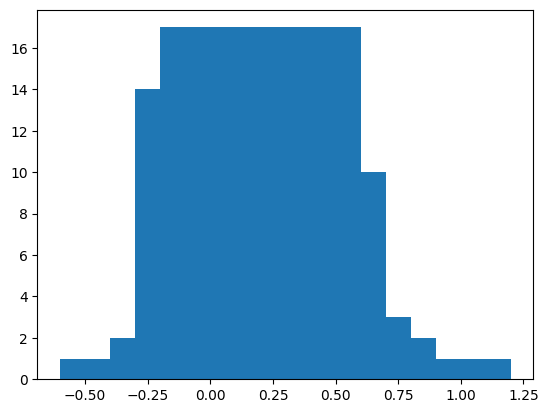

0.212
0.15051910177781422
0.02128661551304011
(0.16878864867853483, 0.25521135132146516)
0.6744897501960817
1.0307039602197032


In [96]:
# Possible values of the sentiment score: -1, -0.9, ...

# Treat the sentiment score as a categorical variable
# Calculate the probability of each value
from collections import Counter
counts = Counter(trial_results)
print(counts)

# show the probability of each value
import numpy as np
import matplotlib.pyplot as plt
plt.bar(counts.keys(), counts.values())
plt.show()

# Calculate the mean of the sentiment score
print(np.mean(trial_results))

# Calculate the standard deviation of the sentiment score
print(np.std(trial_results))

# Calculate the standard error of the sentiment score
print(np.std(trial_results) / np.sqrt(len(trial_results)))

# Calculate the 95% confidence interval of the sentiment score
import scipy.stats as st
print(st.t.interval(0.95, len(trial_results)-1, loc=np.mean(trial_results), scale=st.sem(trial_results)))

# What sample size is needed to get "75% confidence" that the sentiment score is within 0.1 of the true value?
# Use the formula: n = (z * s / e)^2
# n = sample size
# z = z-score for confidence level
# s = standard deviation

# Calculate the z-score for 75% confidence
z = st.norm.ppf(0.75)
print(z)

# n should be at
n = (z * np.std(trial_results) / 0.1)**2

print(n)